## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)  # (5572, 5)
print(df['v2'][0], df['v1'][0])  # ham
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.head(20)
# df.info()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0.5, 1.0, 'Number of ham and spam messages')

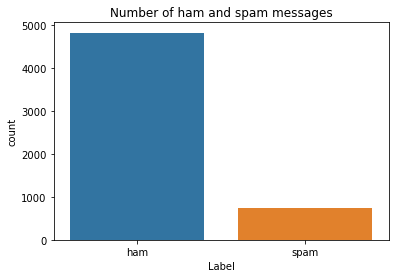

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()


In [6]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)    # Y 값이 0,1로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)
print(Y.shape)  

(5572, 1)


In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3) # 70:30
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
#토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

max_words = 1000
tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000 개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tok.fit_on_texts(X_train)  # 범위 : 0 ~ 999

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train)
sequences

max_len = 150 # 데이터 셋의 길이

# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)   # 신경망에 입력할 X값이다
print(sequences_matrix.shape) # (3900, 150)
# sequences_matrix

word_to_index = tok.word_index
# print(word_to_index)
vocab_size = len(word_to_index)
print(vocab_size) # 7339

sequences_matrix

(3900, 150)
7400


array([[  0,   0,   0, ..., 267,   9, 421],
       [  0,   0,   0, ...,   3, 151, 344],
       [  0,   0,   0, ..., 682,  18, 125],
       ...,
       [  0,   0,   0, ..., 302,   9, 358],
       [  0,   0,   0, ..., 578, 193, 121],
       [  0,   0,   0, ...,  45,  43,  48]])